In [1]:
import numpy as np
import struct
import matplotlib.pyplot as plt
from google.colab import drive

drive.mount('/content/drive')

with open('/content/drive/MyDrive/train-images.idx3-ubyte','rb') as f:
    magic, size = struct.unpack(">II", f.read(8))
    nrows, ncols = struct.unpack(">II", f.read(8))
    data = np.fromfile(f, dtype=np.dtype(np.uint8).newbyteorder('>'))
    print(data.shape)
    Xtraindata = np.transpose(data.reshape((size, nrows*ncols)))

with open('/content/drive/MyDrive/train-labels.idx1-ubyte','rb') as f:
    magic, size = struct.unpack(">II", f.read(8))
    data = np.fromfile(f, dtype=np.dtype(np.uint8).newbyteorder('>'))
    ytrainlabels = data.reshape((size,)) # (Optional)

with open('/content/drive/MyDrive/t10k-images.idx3-ubyte','rb') as f:
    magic, size = struct.unpack(">II", f.read(8))
    nrows, ncols = struct.unpack(">II", f.read(8))
    data = np.fromfile(f, dtype=np.dtype(np.uint8).newbyteorder('>'))
    Xtestdata = np.transpose(data.reshape((size, nrows*ncols)))

with open('/content/drive/MyDrive/t10k-labels.idx1-ubyte','rb') as f:
    magic, size = struct.unpack(">II", f.read(8))
    data = np.fromfile(f, dtype=np.dtype(np.uint8).newbyteorder('>'))
    ytestlabels = data.reshape((size,)) # (Optional)



traindata_imgs =  np.transpose(Xtraindata).reshape((60000,28,28))
print(Xtraindata.shape)
print(ytrainlabels.shape)
print(Xtestdata.shape)
print(ytestlabels.shape)

Mounted at /content/drive
(47040000,)
(784, 60000)
(60000,)
(784, 10000)
(10000,)


In [ ]:
# def plot_digits(XX, N, title):
#     fig, ax = plt.subplots(N, N, figsize=(8, 8))

#     for i in range(N):
#       for j in range(N):
#         ax[i,j].imshow(XX[:,(N)*i+j].reshape((28, 28)), cmap="Greys")
#         ax[i,j].axis("off")
#     fig.suptitle(title, fontsize=24)

# plot_digits(Xtraindata, 8, "First 64 Training Images" )


(60000, 784)
(10000, 784)


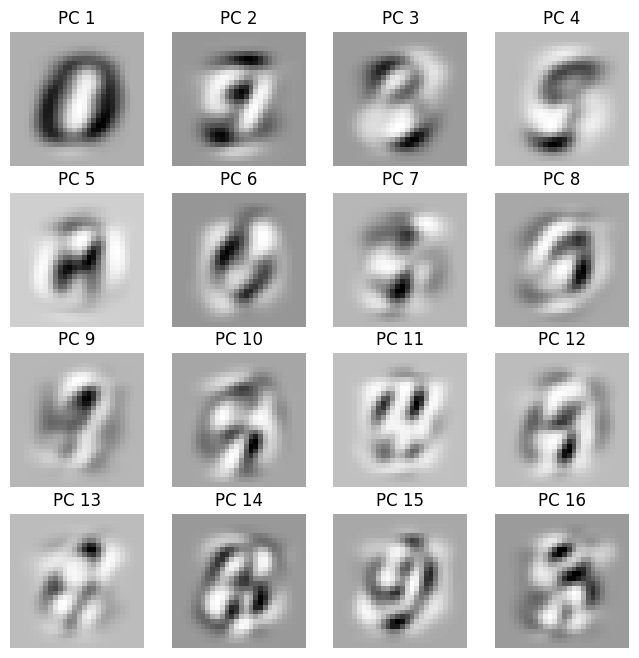

In [2]:
from sklearn.decomposition import PCA

#Task1

#reshape X_data to shape(n_samples, n_features) for PCA()
Xtrain = np.transpose(Xtraindata)
Xtest = np.transpose(Xtestdata)
print(Xtrain.shape)
print(Xtest.shape)

pca = PCA()
pca.fit(Xtrain)

# Visualize first 16 principal components
fig, axes = plt.subplots(4, 4, figsize=(8, 8))
for i, ax in enumerate(axes.flat):
    ax.imshow(pca.components_[i].reshape(28, 28), cmap='Greys')
    ax.set_title(f'PC {i+1}')
    ax.axis('off')
plt.show()



Number of principal components needed for 85% energy: 59


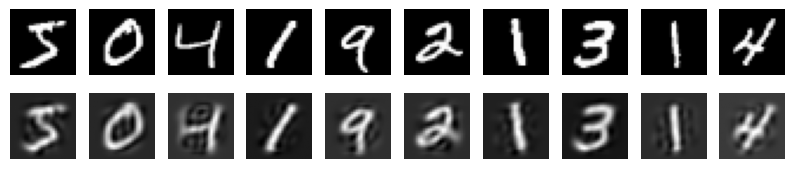

In [3]:
#Task2

# Compute cumulative variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Find k for 85% variance
k = np.argmax(cumulative_variance >= 0.85) + 1
print(f'Number of principal components needed for 85% energy: {k}')

# Digit images reconstructed from 𝑘 truncated PC modes
pca_k = PCA(n_components=k)
X_train_pca = pca_k.fit_transform(Xtrain)

# fig, axes = plt.subplots(4, 4, figsize=(8, 8))
# for i, ax in enumerate(axes.flat):
#     ax.imshow(pca_k.components_[i].reshape(28, 28), cmap='Greys')
#     ax.set_title(f'{i+1}')
#     ax.axis('off')
# plt.show()

X_train_reconstructed = pca_k.inverse_transform(X_train_pca)

fig, axes = plt.subplots(2, 10, figsize=(10, 2))
for i in range(10):
    axes[0, i].imshow(traindata_imgs[i], cmap='gray')
    axes[0, i].axis('off')
    axes[1, i].imshow(X_train_reconstructed[i].reshape(28, 28), cmap='gray')
    axes[1, i].axis('off')
plt.show()

In [4]:
#Task 3
import pandas as pd

# Function to select specific digits(all samples of them)
def select_digits(X, y, digits):
    mask = np.isin(y, digits)
    return X[mask], y[mask]


In [5]:
#Task 4 & 5
from sklearn.linear_model import RidgeClassifier
from sklearn.model_selection import cross_val_score

X_test_pca = pca_k.transform(Xtestdata.T)

for pair in [(1, 8), (3, 8), (2, 7)]:
    X_subtrain, y_subtrain = select_digits(X_train_pca, ytrainlabels, pair)
    X_subtest, y_subtest = select_digits(X_test_pca, ytestlabels, pair)

    clf = RidgeClassifier()
    crossValid = cross_val_score(clf, X_subtrain, y_subtrain, cv=5)
    print(f'Cross-validation accuracy for {pair}: {crossValid.mean():.4f} ± {crossValid.std():.4f}')

    # Train on full training set and evaluate on test set
    clf.fit(X_subtrain, y_subtrain)
    test_accuracy = clf.score(X_subtest, y_subtest)
    print(f'Test set accuracy for {pair}: {test_accuracy:.4f}')


Cross-validation accuracy for (1, 8): 0.9643 ± 0.0027
Test set accuracy for (1, 8): 0.9801
Cross-validation accuracy for (3, 8): 0.9588 ± 0.0061
Test set accuracy for (3, 8): 0.9642
Cross-validation accuracy for (2, 7): 0.9797 ± 0.0014
Test set accuracy for (2, 7): 0.9748


In [6]:
#Task 6
from sklearn.neighbors import KNeighborsClassifier

# Multi-class classification using Ridge and KNN
ridge = RidgeClassifier()
ridge.fit(X_train_pca, ytrainlabels)
print(f'Multi-class Ridge accuracy: {ridge.score(pca_k.transform(Xtestdata.T), ytestlabels):.4f}')

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_pca, ytrainlabels)
print(f'Multi-class KNN accuracy: {knn.score(pca_k.transform(Xtestdata.T), ytestlabels):.4f}')


Multi-class Ridge accuracy: 0.8561
Multi-class KNN accuracy: 0.9760


In [11]:
# Bonus: SVM Classifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

svm = SVC()
#svm.fit(X_train_pca, ytrainlabels)

#search the hyper-parameter space
#svm.get_params()
param_grid = [{'C': [1, 10, 100]}]
grid_search = GridSearchCV(svm, param_grid, cv=5)
grid_search.fit(X_train_pca, ytrainlabels)
best_C = grid_search.best_params_['C']
best_model = grid_search.best_estimator_

print(f"Best value for C: {best_C}")
print(f"Best model: {best_model}")

#evaluate the best model on the test data
test_score = best_model.score(X_test_pca, ytestlabels)
print(f"Test score: {test_score}")
print(f'Multi-class SVM accuracy: {best_model.score(X_test_pca, ytestlabels):.4f}')


Best value for C: 10
Best model: SVC(C=10)
Test score: 0.9858
Multi-class SVM accuracy: 0.9858
